Loading: data/raw/twitter/twitter_incremental_20251126_114113.parquet
Raw shape: (5, 9)


id                                               text  \
0  1993563119344664692  RT @FT: OpenAI needs to raise at least $207bn ...   
1  1993563074306158796  RT @lexifdev: 사실 원트의 원트처럼 따지고 들어가면\n\n앱은 API의 ...   
2  1993563038637867270  RT @Alter__Egaux: 6/9\nPreuve de l'autonomie p...   
3  1993562959323545772  RT @dotey: Ilya：扩展时代已经结束了，研究的时代已经开始\n\nIlya Su...   
4  1993562935118237787  @OpenAI I’m not going to twist your words or p...   

                  created_at lang            author_id  retweet_count  \
0  2025-11-26T06:11:00+00:00   en            588069330            366   
1  2025-11-26T06:10:50+00:00   ko  1160384332634021888              3   
2  2025-11-26T06:10:41+00:00   fr   860779676725379072              0   
3  2025-11-26T06:10:22+00:00   zh  1137646458792886272             17   
4  2025-11-26T06:10:16+00:00   en  1976189975747256320              0   

   reply_count  like_count  quote_count  
0            0           0            0  
1            0           0            0  
2            0           0            0  
3            0           0            0  
4            0           0            0

After lang filter (en): 2


text  \
0  RT @FT: OpenAI needs to raise at least $207bn ...   
4  @OpenAI I’m not going to twist your words or p...   

                                               clean  
0  rt openai needs raise least 207bn 2030 continu...  
4  going twist words pretend please reach someone...

Using local TF-IDF + LogisticRegression model
Saved processed: data/processed/twitter_processed_20251128_003205.parquet


created_at  \
0  2025-11-26T06:11:00+00:00   
4  2025-11-26T06:10:16+00:00   

                                                text      pred  
0  RT @FT: OpenAI needs to raise at least $207bn ...  NEGATIVE  
4  @OpenAI I’m not going to twist your words or p...  POSITIVE

Counts:
 pred
NEGATIVE    1
POSITIVE    1


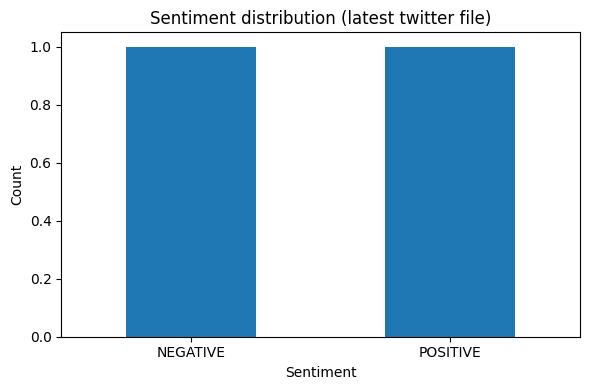

In [1]:
import glob, os, pandas as pd, re
from datetime import datetime
import matplotlib.pyplot as plt

# 1) find latest raw twitter parquet
files = sorted(glob.glob("data/raw/twitter/*.parquet"))
if not files:
    raise SystemExit("No twitter parquet files found in data/raw/twitter")
f = files[-1]
print("Loading:", f)
df = pd.read_parquet(f)
print("Raw shape:", df.shape)
display(df.head(6))

# 2) optional: filter English tweets
df = df[df.get('lang','').astype(str)=='en'].copy()
print("After lang filter (en):", len(df))

# 3) NLTK resources (download if missing)
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except:
    nltk.download("punkt")
try:
    nltk.data.find("corpora/stopwords")
except:
    nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words("english"))

# 4) cleaning function
def clean_text(txt):
    if not isinstance(txt, str): 
        return ""
    t = txt.lower()
    t = re.sub(r'http\S+|www\S+','', t)
    t = re.sub(r'@\w+','', t)
    t = re.sub(r'[^a-z0-9\s]',' ', t)
    toks = word_tokenize(t)
    toks = [w for w in toks if w not in stop_words and len(w)>1]
    return " ".join(toks)

df['clean'] = df['text'].astype(str).apply(clean_text)
display(df[['text','clean']].head(6))

# 5) Prediction: prefer local TF-IDF + LogisticRegression model if present
import joblib
vect_path = os.path.join("models","tfidf_vectorizer.joblib")
clf_path = os.path.join("models","logreg_sentiment.joblib")

if os.path.exists(vect_path) and os.path.exists(clf_path):
    print("Using local TF-IDF + LogisticRegression model")
    vect = joblib.load(vect_path)
    clf = joblib.load(clf_path)
    X = vect.transform(df['clean'].fillna(""))
    df['pred'] = clf.predict(X)
    try:
        probs_arr = clf.predict_proba(X)
        df['pred_proba'] = list(probs_arr)
    except Exception:
        df['pred_proba'] = None
else:
    print("Local model not found — using Hugging Face sentiment pipeline (may download model; this can take time)")
    try:
        from transformers import pipeline
        pipe = pipeline("sentiment-analysis", truncation=True)
        out = pipe(list(df['text'].astype(str)))
        df['pred'] = [o['label'] for o in out]
        df['pred_proba'] = [{o['label']: float(o.get('score',0.0))} for o in out]
    except Exception as e:
        raise SystemExit(f"Hugging Face pipeline failed: {e}\nInstall 'transformers' and retry or save a local model in models/")

# 6) Save processed
os.makedirs("data/processed", exist_ok=True)
fname = f"data/processed/twitter_processed_{datetime.now().strftime('%Y%m%d_%H%M%S')}.parquet"
df.to_parquet(fname, index=False)
print("Saved processed:", fname)

# 7) Show predictions and plot counts
display(df[['created_at','text','pred']].head(10))
counts = df['pred'].value_counts()
print("Counts:\n", counts.to_string())

plt.figure(figsize=(6,4))
counts.sort_index().plot(kind='bar')
plt.title("Sentiment distribution (latest twitter file)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
